# Fine-tune Phi 2 using QLoRA

In [4]:
# Install and import the necessary libraries
!pip install torch
!pip install -q -U accelerate peft bitsandbytes transformers trl einops
# !pip install tqdm
# !pip install git+https://github.com/sissa-data-science/DADApy

In [5]:
import os
import torch
from datasets import load_dataset
from datasets import load_from_disk
from peft import LoraConfig, prepare_model_for_kbit_training, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    pipeline,
    logging,
)
from tqdm import tqdm
from trl import SFTTrainer

2024-05-21 04:47:10.083766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 04:47:10.083891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 04:47:10.214074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Model
base_model = "microsoft/phi-2"
new_model = "phi-2-medquad"

# Dataset
dataset = load_dataset("prsdm/MedQuad-phi2-1k", split="train")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
tokenizer.pad_token=tokenizer.eos_token
tokenizer.padding_side="right"

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Intrinsic dimentions of base model phi2 on medQuad.

In [ ]:
# samples = 250 train, 100 test
train_dataset = dataset.select(range(800))
test_dataset = dataset.select(range(800,1000))

In [ ]:
# Function that tokenizes the text
def tokenize(rows):
    # Retrieve Text
    if rows["text"][0] is None:
        text = ""
    else:
        text = rows["text"][0].replace('"', r'\"')

    # Tokenize
    encoded = tokenizer(
          text,
          add_special_tokens=True,
          max_length=260,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
        ).to("cuda")
    return encoded

In [ ]:
# Applying tokenization to the dataset
tokenized_dataset = train_dataset.map(tokenize,
                                batched=True,
                                batch_size=1,
                                remove_columns=["text"])

In [ ]:
normal_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    device_map={"": 0},
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# computing intrinsic dimentions before finetuning
# Constants
from tqdm import tqdm
import gc
torch.cuda.empty_cache()
gc.collect()
num_data = 250
per_batch = 50
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

        # Perform forward pass through the model
        with torch.no_grad():
            outputs = normal_model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        del outputs
        torch.cuda.empty_cache()
        gc.collect()
        hidden_layers.append(liste)
del liste

100%|██████████| 5/5 [03:13<00:00, 38.76s/it]


In [ ]:
len(hidden_layers[249])

33

In [ ]:
# Move back to CPU
torch.set_default_device("cpu")

# Process hidden layers
hidden_layers_avg = []

for j in range(33):
    avg_batch_layer = []
    for i in range(number_batches * per_batch):
        layer = hidden_layers[i][j].detach().cpu()
        avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
    hidden_layers_avg.append(avg_batch_layer)

# Handle empty tensors
for layer in hidden_layers_avg:
    for idx, tensor in enumerate(layer):
        if tensor.shape == torch.Size([]):
            print("Encountered empty tensor. Filling with zeros.")
            layer[idx] = torch.zeros(2560)


# Stack hidden layers
hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
hidden_layers_stacked = torch.stack(hidden_layers_stacked)

In [ ]:
# Assuming 'phi2_model' is your loaded model
embedding_size = normal_model.config.hidden_size
print(f"Embedding size for phi2 model: {embedding_size}")

Embedding size for phi2 model: 2560


In [ ]:
gc.collect()

22301

In [ ]:
import matplotlib.pyplot as plt
from dadapy.data import Data
import numpy as np

In [ ]:
len(hidden_layers_stacked)

33

No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 0: 13.038541154569742
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 1: 13.67312334964858
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 2: 14.24142693403802
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 3: 13.37564809912871
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 4: 12.849894912600835
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 5: 11.956869564525753
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 6: 10.942497139069395
No identical identical points were found
No identical identical p

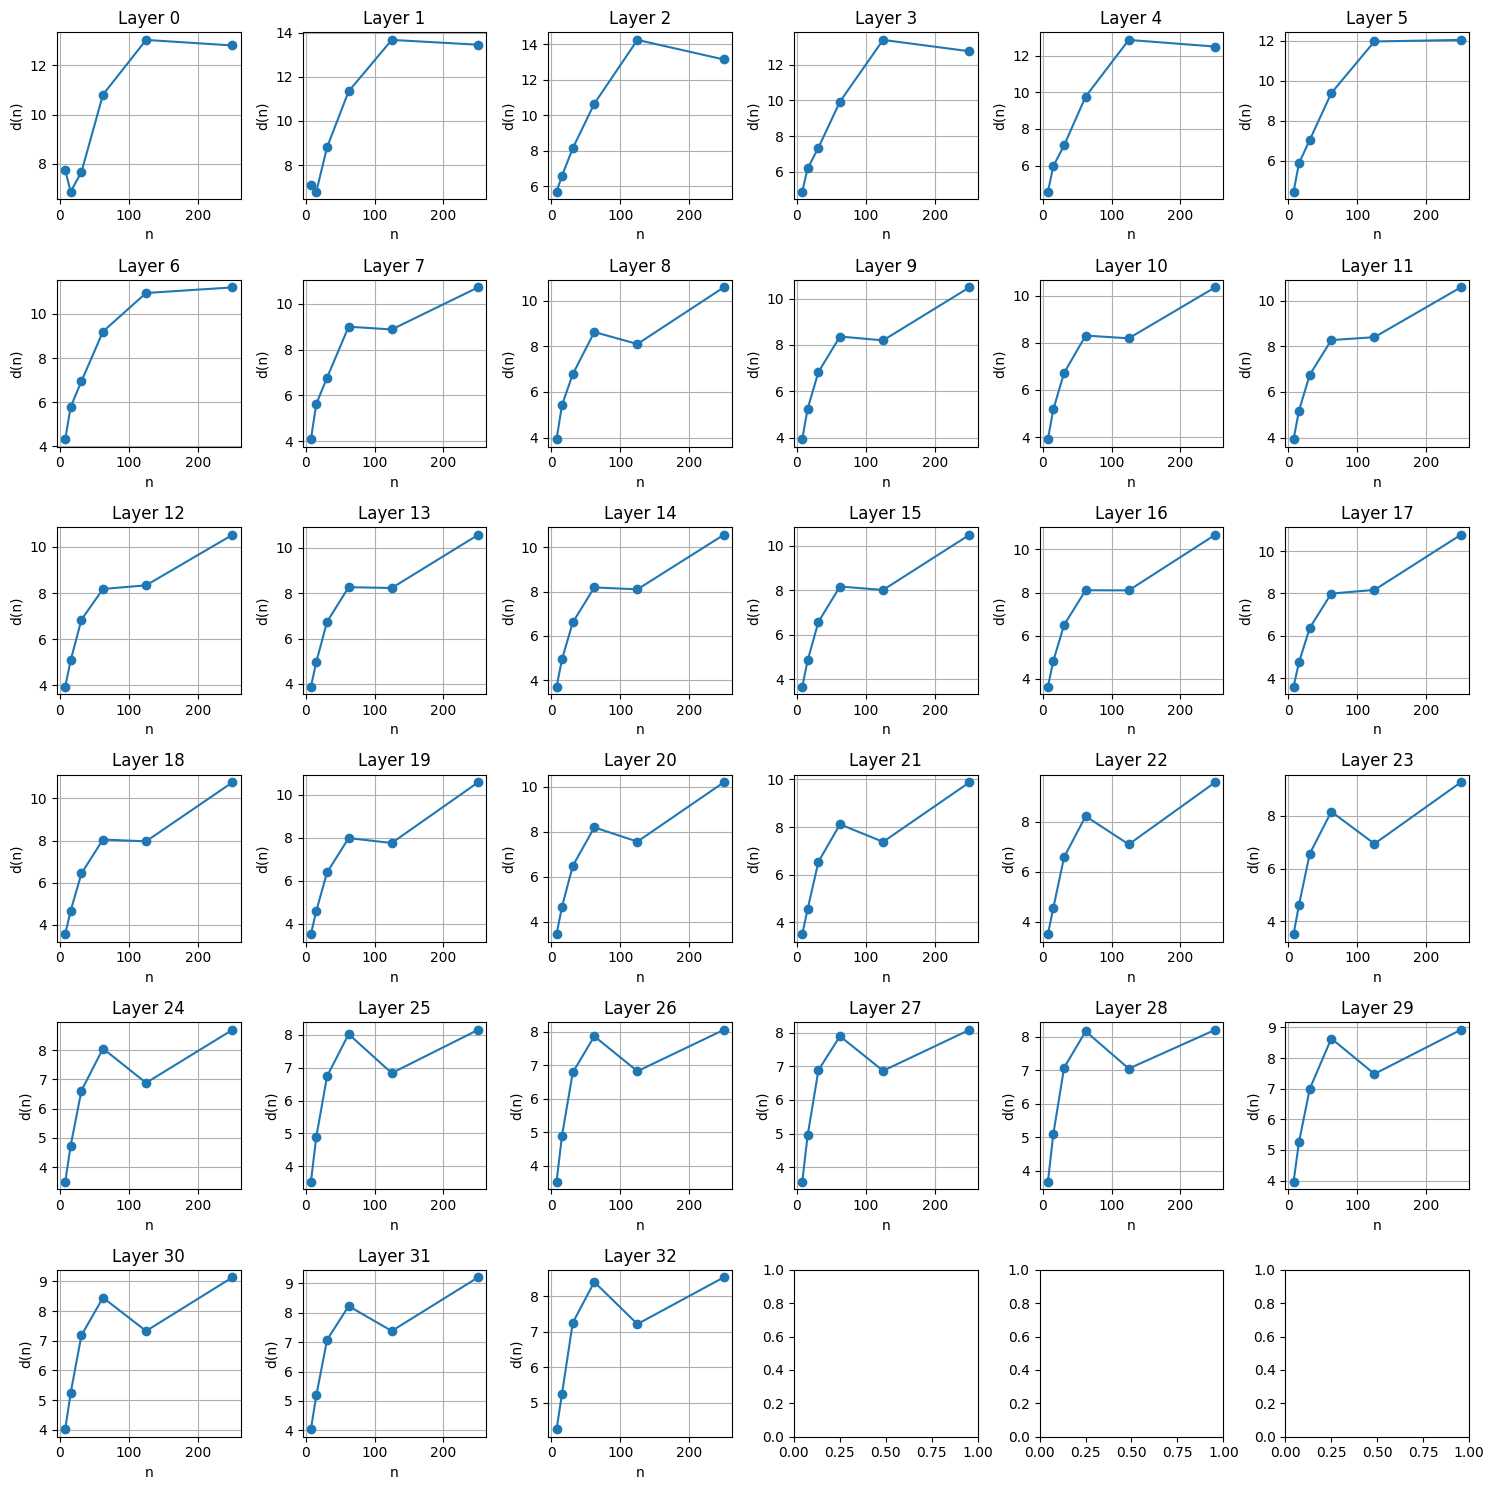

In [ ]:

# Compute intrinsic dimensions
intrinsic_dims = []

# Check which id to pick
fig, axes = plt.subplots(6, 6, figsize=(15, 15))

# # Flatten the axes array for easy iteration
axes = axes.flatten()

# n = len(id_list_2NN)
# ax = axes[i]
# ax.plot([per_batch * number_batches / 2**i for i in range(n)], id_list_2NN,  marker='o')
# ax.set_title(f'Figure {i+1}')
# ax.set_xlabel('n')
# ax.set_ylabel('d(n)')
# ax.grid(True)
# plt.tight_layout()
# plt.show()
# plt.savefig('ids_n.png')

for i in range(0, 33):
    X = hidden_layers_stacked[i].numpy()
    data = Data(X)
    data.remove_identical_points()
    data.remove_identical_points()
    #id_list_2NN, _, _ = data.return_id_scaling_2NN()
    id_list_2NN, _, _ = data.return_id_scaling_gride()
    n = len(id_list_2NN)
    ax = axes[i]
    ax.plot([per_batch * number_batches / 2**j for j in range(n)], id_list_2NN,  marker='o')
    ax.set_title(f'Layer {i}')
    intrinsic_dims.append(id_list_2NN[1])
    print(f"Intrinsic dimension for layer {i}: {id_list_2NN[1]}")
    ax.set_xlabel('n')
    ax.set_ylabel('d(n)')
    ax.grid(True)

plt.tight_layout()
plt.savefig('ids_n.png')
plt.show()


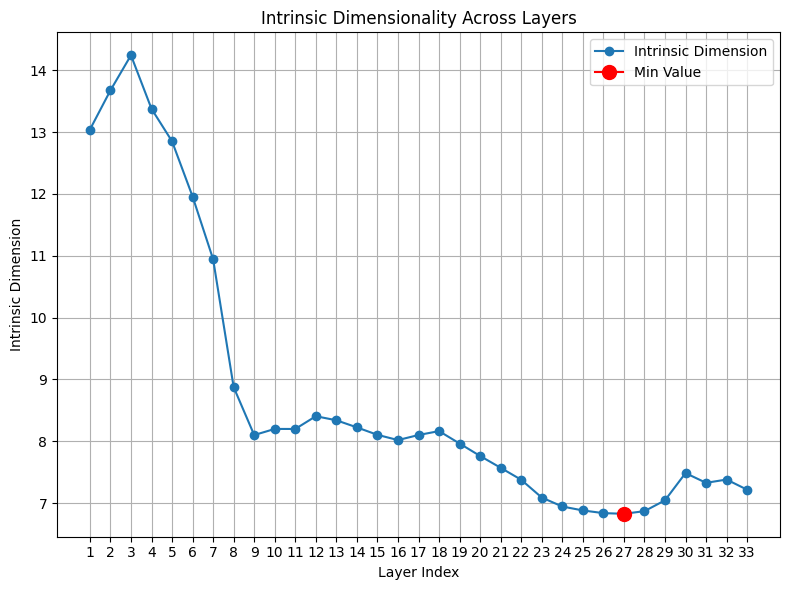

In [ ]:
# Plot results
# Find the index of the minimum value
min_index = intrinsic_dims.index(min(intrinsic_dims)) + 1

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 34), intrinsic_dims, marker='o', linestyle='-', label='Intrinsic Dimension')
plt.plot(min_index, min(intrinsic_dims), marker='o', color='red', markersize=10, label='Min Value')
plt.title('Intrinsic Dimensionality Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 34))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer4.png")
plt.show()


In [ ]:
intrinsic_dims

[13.038541154569742,
 13.67312334964858,
 14.24142693403802,
 13.37564809912871,
 12.849894912600835,
 11.956869564525753,
 10.942497139069395,
 8.873846494516446,
 8.09909189381203,
 8.198273108629714,
 8.19762816839173,
 8.404009568413866,
 8.338216641961449,
 8.223261457848508,
 8.102856179479016,
 8.017943627143012,
 8.099834273576938,
 8.163210653195417,
 7.962214736990835,
 7.7607312156983825,
 7.569553408672596,
 7.375930591295154,
 7.088577235432603,
 6.943829886857157,
 6.879999604352779,
 6.836669341030152,
 6.825771422613557,
 6.868200224793081,
 7.043714307723131,
 7.484154298985582,
 7.326697844227746,
 7.379606692444038,
 7.215366898289678]

In [ ]:
import pickle
# File path to save the pickle file
file_path = 'intrinsic_dims.pkl'

# Save the list to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(intrinsic_dims, file)

print(f'Intrinsic dimensions saved to {file_path}')

Intrinsic dimensions saved to intrinsic_dims.pkl


## QLoRA model loading

In [10]:
# Quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

In [9]:
# Load base moodel
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    device_map={"": 0},
    revision="refs/pr/23" #the main version of Phi-2 doesn’t support gradient checkpointing (while training this model)
)

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/577M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [10]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


## QLoRA

In [9]:
def find_target_modules(model):
    unique_layers = set()

    for name, module in model.named_modules():
        if "Linear" in str(type(module)):
            layer_type = name.split('.')[-1]
            unique_layers.add(layer_type)
    return list(unique_layers)

In [10]:
find_target_modules(model)

['linear', 'out_proj', 'fc1', 'Wqkv', 'fc2']

In [7]:
train_dataset = dataset.select(range(250))
test_dataset = dataset.select(range(990,1000))

## Rank = 1, training samples = 250, testing samples = 100, target modules = all unique layers

In [12]:
# Set training arguments
# rank = 1
training_arguments = TrainingArguments(
    output_dir = "./results",
    report_to="none",
    num_train_epochs = 1,
    fp16 = False,
    bf16 = False,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 1,
    gradient_checkpointing = True,
    max_grad_norm = 0.3,
    learning_rate = 2e-4,
    weight_decay = 0.001,
    optim = "paged_adamw_32bit",
    lr_scheduler_type = "cosine",
    max_steps = -1,
    warmup_ratio = 0.03,
    group_by_length = True,
    save_steps = 0,
    logging_steps = 50,
)

In [13]:
# LoRA configuration
peft_config = LoraConfig(
    r=1,                   #default=8
    lora_alpha= 16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules= ['fc2', 'Wqkv', 'out_proj', 'fc1']
)
#print_trainable_parameters(model)

In [14]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length= None,
    tokenizer=tokenizer,
    args=training_arguments,
)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [15]:
# Training the model and getting the training output
train_output = trainer.train()

Step,Training Loss
50,1.230300
100,1.201600
150,1.168300
200,1.131600
250,1.079100


In [16]:
# Extracting training time from train_output
training_time = train_output.metrics['train_runtime']

In [17]:
# Save trained model
trainer.model.save_pretrained(f"{new_model}_rank_{peft_config.r}")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

You are using a model of type phi to instantiate a model of type phi-msft. This is not supported for all configurations of models and can yield errors.


In [18]:
details_save_path = os.path.join("./results/saved_model", "training_details.txt")
# Ensure the directory exists
os.makedirs("./results/saved_model", exist_ok=True)
with open(details_save_path, "w") as f:
    f.write(f"Model name: {new_model}_rank_{peft_config.r}\n")
    f.write(f"Training time: {training_time:.2f} seconds\n")

## Inference

In [ ]:
# #Check training results with tensorboard
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
# Clear the memory
# del model, pipe, trainer

In [ ]:
# # Run text generation pipeline with our model
# logging.set_verbosity(logging.CRITICAL)

# prompt = "What are the treatments for Gastrointestinal Carcinoid Tumors?"
# instruction = f"### Instruction: {prompt} "
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
# result = pipe(instruction)
# print(result[0]['generated_text'][len(instruction):])

In [31]:
for prompt in test_dataset.select(range(1)):
  # Extract the instruction part
  instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
  print(instruction)

What are the symptoms of Schwannomatosis ? 


In [37]:
for prompt in test_dataset.select(range(1)):
  print(prompt["text"])

### Instruction: What are the symptoms of Schwannomatosis ? ### Assistant: What are the signs and symptoms of Schwannomatosis? Signs and symptoms of the schwannomatosis often develop during adulthood between ages 25 and 30. Affected people generally have multiple schwannomas, which are benign tumors of the nervous system. In schwannomatosis, these tumors can grow along any nerve in the body, although they are less common on the vestibular nerve (vestibular schwannomas, also known as acoustic neuromas). People with vestibular schwannomas, especially those with tumors affecting the vestibular nerve on both sides of the head (bilateral), may have neurofibromatosis type 2 instead. The signs and symptoms associated with schwannomatosis vary based on the size and location of the schwannomas. The most common symptom is chronic pain, which can develop as a growing schwannoma presses on nerves or surrounding tissues. Some people may develop a mass if the schwannomas is located just beneath the 

In [19]:
# Initializing the text-generation pipeline
# pipelines - easy way to use models for inference
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=256)

# List to store results
results = []

# Iterating over the testing dataset and generating predictions
for prompt in test_dataset.select(range(1)):
    # Extract the instruction part
    instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
    result = pipe(f"### Instruction: {instruction}")
    generated_text = result[0]['generated_text']
    results.append({
        "prompt": instruction,
        "generated_text": generated_text
    })

# Printing the required result
# print(f"Prompt: {results[-1]['prompt']}")
print(f"{results[-1]['generated_text']}")

### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: Key Points
                - Schwannomatosis is a rare condition that causes tumors to form in the skin, nerves, and other tissues.
                - The tumors are usually benign (noncancerous).
                - The tumors can cause pain, numbness, and weakness in the affected area.
                - The symptoms of Schwannomatosis vary depending on the location and size of the tumors.
                - The symptoms of Schwannomatosis can be similar to those of other conditions, such as multiple myeloma.
                - The symptoms of Schwannomatosis can be treated with surgery, radiation therapy, and chemotherapy.
                - The prognosis for Schwannomatosis is generally good, with most patients living for many years after diagnosis.
                - The National Cancer Institute has information about the treatment of Schwannomatosis.
                - Key Points
                - Schwannomatosis 

In [ ]:
# # Reload model and merge it with LoRA parameters
# model = AutoModelForCausalLM.from_pretrained(
#     base_model,
#     torch_dtype=torch.float16,
#     trust_remote_code=True,
#     cache_dir="",
#     device_map={"": 0},
# )
# model = PeftModel.from_pretrained(model, new_model)
# model = model.merge_and_unload()

In [ ]:
# # Reload tokenizer to save it
# tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.padding_side = "right"

In [ ]:
# !huggingface-cli login

In [ ]:
# model.push_to_hub(new_model, use_temp_dir=False)
# tokenizer.push_to_hub(new_model, use_temp_dir=False)

## Rank = 64, training samples = 250, testing samples = 100, target modules = all unique layers

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    device_map={"": 0},
    revision="refs/pr/23" #the main version of Phi-2 doesn’t support gradient checkpointing (while training this model)
)

In [ ]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

In [9]:
# Set training arguments
# rank = 64
training_arguments = TrainingArguments(
    output_dir = "./results",
    report_to="none",
    num_train_epochs = 1,
    fp16 = False,
    bf16 = False,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 1,
    gradient_checkpointing = True,
    max_grad_norm = 0.3,
    learning_rate = 2e-4,
    weight_decay = 0.001,
    optim = "paged_adamw_32bit",
    lr_scheduler_type = "cosine",
    max_steps = -1,
    warmup_ratio = 0.03,
    group_by_length = True,
    save_steps = 0,
    logging_steps = 50,
)

In [10]:
# LoRA configuration
peft_config = LoraConfig(
    r=64,                   #default=8
    lora_alpha= 16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules= ['fc2', 'Wqkv', 'out_proj', 'fc1']
)
#print_trainable_parameters(model)

In [13]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length= None,
    tokenizer=tokenizer,
    args=training_arguments,
)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [14]:
# Training the model and getting the training output
train_output = trainer.train()

Step,Training Loss
50,1.224200
100,1.190100
150,1.154600
200,1.118500
250,1.064900


In [15]:
# Extracting training time from train_output
training_time = train_output.metrics['train_runtime']

In [16]:
# Save trained model
trainer.model.save_pretrained(f"{new_model}_rank_{peft_config.r}")

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

You are using a model of type phi to instantiate a model of type phi-msft. This is not supported for all configurations of models and can yield errors.


In [17]:
details_save_path = os.path.join("./results/saved_model", "training_details.txt")
# Ensure the directory exists
os.makedirs("./results/saved_model", exist_ok=True)
with open(details_save_path, "w") as f:
    f.write(f"Model name: {new_model}_rank_{peft_config.r}\n")
    f.write(f"Training time: {training_time:.2f} seconds\n")

## Inference

In [ ]:
# #Check training results with tensorboard
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
# Clear the memory
# del model, pipe, trainer

In [ ]:
# # Run text generation pipeline with our model
# logging.set_verbosity(logging.CRITICAL)

# prompt = "What are the treatments for Gastrointestinal Carcinoid Tumors?"
# instruction = f"### Instruction: {prompt} "
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
# result = pipe(instruction)
# print(result[0]['generated_text'][len(instruction):])

In [19]:
for prompt in test_dataset.select(range(1)):
  # Extract the instruction part
  instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
  print(instruction)

What are the symptoms of Schwannomatosis ? 


In [ ]:
for prompt in test_dataset.select(range(1)):
  print(prompt["text"])

### Instruction: What are the symptoms of Schwannomatosis ? ### Assistant: What are the signs and symptoms of Schwannomatosis? Signs and symptoms of the schwannomatosis often develop during adulthood between ages 25 and 30. Affected people generally have multiple schwannomas, which are benign tumors of the nervous system. In schwannomatosis, these tumors can grow along any nerve in the body, although they are less common on the vestibular nerve (vestibular schwannomas, also known as acoustic neuromas). People with vestibular schwannomas, especially those with tumors affecting the vestibular nerve on both sides of the head (bilateral), may have neurofibromatosis type 2 instead. The signs and symptoms associated with schwannomatosis vary based on the size and location of the schwannomas. The most common symptom is chronic pain, which can develop as a growing schwannoma presses on nerves or surrounding tissues. Some people may develop a mass if the schwannomas is located just beneath the 

In [20]:
# Initializing the text-generation pipeline
# pipelines - easy way to use models for inference
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=256)

# List to store results
results = []

# Iterating over the testing dataset and generating predictions
for prompt in test_dataset.select(range(1)):
    # Extract the instruction part
    instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
    result = pipe(f"### Instruction: {instruction}")
    generated_text = result[0]['generated_text']
    results.append({
        "prompt": instruction,
        "generated_text": generated_text
    })

# Printing the required result
# print(f"Prompt: {results[-1]['prompt']}")
print(f"{results[-1]['generated_text']}")

### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis? The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis a person has. The following table lists the signs and symptoms that occur in some people with Schwannomatosis. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Abdominal pain (90%) Abnormal bone formation (90%) Abnormal skin pigmentation (90%) Abnormal skin texture (90%) Abnormal sensation (90%) Abnormal sensation of touch (90%) Abnormal sensation of temperature (90%) Abnormal sensation of pain (90%) Abnormality of the eye (90%) Abnormality of the jaw (90%) Abnormality of the mouth (90%) Abnormality of the nose (90%) Abnormality of the skin (90%) Abnormality of the tongue (90%) Abnormality of the teeth (90%) Abnormality of the urethra (90%) Abnormality of the

## Rank = 14, training samples = 250, testing samples = 100, target modules = all unique layers

In [8]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    device_map={"": 0},
    revision="refs/pr/23" #the main version of Phi-2 doesn’t support gradient checkpointing (while training this model)
)

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/577M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [9]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [10]:
# Set training arguments
# rank = 14
training_arguments = TrainingArguments(
    output_dir = "./results",
    report_to="none",
    num_train_epochs = 1,
    fp16 = False,
    bf16 = False,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 1,
    gradient_checkpointing = True,
    max_grad_norm = 0.3,
    learning_rate = 2e-4,
    weight_decay = 0.001,
    optim = "paged_adamw_32bit",
    lr_scheduler_type = "cosine",
    max_steps = -1,
    warmup_ratio = 0.03,
    group_by_length = True,
    save_steps = 0,
    logging_steps = 50,
)

In [11]:
# LoRA configuration
peft_config = LoraConfig(
    r=14,                   #default=8
    lora_alpha= 16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules= ['fc2', 'Wqkv', 'out_proj', 'fc1']
)
#print_trainable_parameters(model)

In [14]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length= None,
    tokenizer=tokenizer,
    args=training_arguments,
)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [15]:
# Training the model and getting the training output
train_output = trainer.train()

Step,Training Loss
50,1.227100
100,1.198000
150,1.162200
200,1.125600
250,1.072500


In [16]:
# Extracting training time from train_output
training_time = train_output.metrics['train_runtime']

In [17]:
# Save trained model
trainer.model.save_pretrained(f"{new_model}_rank_{peft_config.r}")

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

You are using a model of type phi to instantiate a model of type phi-msft. This is not supported for all configurations of models and can yield errors.


In [18]:
details_save_path = os.path.join("./results/saved_model", "training_details.txt")
# Ensure the directory exists
os.makedirs("./results/saved_model", exist_ok=True)
with open(details_save_path, "w") as f:
    f.write(f"Model name: {new_model}_rank_{peft_config.r}\n")
    f.write(f"Training time: {training_time:.2f} seconds\n")

## Inference

In [ ]:
# #Check training results with tensorboard
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
# Clear the memory
# del model, pipe, trainer

In [ ]:
# # Run text generation pipeline with our model
# logging.set_verbosity(logging.CRITICAL)

# prompt = "What are the treatments for Gastrointestinal Carcinoid Tumors?"
# instruction = f"### Instruction: {prompt} "
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
# result = pipe(instruction)
# print(result[0]['generated_text'][len(instruction):])

In [ ]:
for prompt in test_dataset.select(range(1)):
  # Extract the instruction part
  instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
  print(instruction)

What are the symptoms of Schwannomatosis ? 


In [ ]:
for prompt in test_dataset.select(range(1)):
  print(prompt["text"])

### Instruction: What are the symptoms of Schwannomatosis ? ### Assistant: What are the signs and symptoms of Schwannomatosis? Signs and symptoms of the schwannomatosis often develop during adulthood between ages 25 and 30. Affected people generally have multiple schwannomas, which are benign tumors of the nervous system. In schwannomatosis, these tumors can grow along any nerve in the body, although they are less common on the vestibular nerve (vestibular schwannomas, also known as acoustic neuromas). People with vestibular schwannomas, especially those with tumors affecting the vestibular nerve on both sides of the head (bilateral), may have neurofibromatosis type 2 instead. The signs and symptoms associated with schwannomatosis vary based on the size and location of the schwannomas. The most common symptom is chronic pain, which can develop as a growing schwannoma presses on nerves or surrounding tissues. Some people may develop a mass if the schwannomas is located just beneath the 

In [19]:
# Initializing the text-generation pipeline
# pipelines - easy way to use models for inference
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=256)

# List to store results
results = []

# Iterating over the testing dataset and generating predictions
for prompt in test_dataset.select(range(1)):
    # Extract the instruction part
    instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
    result = pipe(f"### Instruction: {instruction}")
    generated_text = result[0]['generated_text']
    results.append({
        "prompt": instruction,
        "generated_text": generated_text
    })

# Printing the required result
# print(f"Prompt: {results[-1]['prompt']}")
print(f"{results[-1]['generated_text']}")

### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis? The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis. The following table lists the signs and symptoms of the different types of Schwannomatosis. You can use the MedlinePlus Medical Dictionary to look up the definitions for medical terms used in this table. Signs and Symptoms of Schwannomatosis Type of Schwannomatosis Abnormal bone formation (osteolysis) Abnormal bone formation (osteolysis) Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality of the skin Abnormality

## Rank = Intrinsic dimentions, training samples = 250, testing samples = 100, target modules = all unique layers

In [8]:
import pickle

# Load the pickle file
with open("/kaggle/input/intrinsic-dims/intrinsic_dims.pkl", "rb") as f:
    id = pickle.load(f)

In [11]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    device_map={"": 0},
    revision="refs/pr/23" #the main version of Phi-2 doesn’t support gradient checkpointing (while training this model)
)

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/577M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [12]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [13]:
def find_target_modules(model):
    unique_layers = set()
    
    for name, module in model.named_modules():
        print(name)
        if "Linear" in str(type(module)):
            layer_type = name.split('.')[-1]
            unique_layers.add(layer_type)
    return list(unique_layers)

In [14]:
find_target_modules(model)


transformer
transformer.embd
transformer.embd.wte
transformer.embd.drop
transformer.h
transformer.h.0
transformer.h.0.ln
transformer.h.0.resid_dropout
transformer.h.0.mixer
transformer.h.0.mixer.rotary_emb
transformer.h.0.mixer.Wqkv
transformer.h.0.mixer.out_proj
transformer.h.0.mixer.inner_attn
transformer.h.0.mixer.inner_attn.drop
transformer.h.0.mixer.inner_cross_attn
transformer.h.0.mixer.inner_cross_attn.drop
transformer.h.0.mlp
transformer.h.0.mlp.fc1
transformer.h.0.mlp.fc2
transformer.h.0.mlp.act
transformer.h.1
transformer.h.1.ln
transformer.h.1.resid_dropout
transformer.h.1.mixer
transformer.h.1.mixer.rotary_emb
transformer.h.1.mixer.Wqkv
transformer.h.1.mixer.out_proj
transformer.h.1.mixer.inner_attn
transformer.h.1.mixer.inner_attn.drop
transformer.h.1.mixer.inner_cross_attn
transformer.h.1.mixer.inner_cross_attn.drop
transformer.h.1.mlp
transformer.h.1.mlp.fc1
transformer.h.1.mlp.fc2
transformer.h.1.mlp.act
transformer.h.2
transformer.h.2.ln
transformer.h.2.resid_dropout


['fc2', 'linear', 'fc1', 'out_proj', 'Wqkv']

In [40]:
r_values = {}
for i in range(32):
    r_values.update({
        f'model.layers.{i}.mlp.fc2': int(id[i]),
        f'model.layers.{i}.mlp.fc1': int(id[i]),
        f'model.layers.{i}.mixer.out_proj': int(id[i]),
        f'model.layers.{i}.mixer.Wqkv': int(id[i]),
    })

In [41]:
r_values.update({
    'lm_head.linear': int(id[32])
})

In [18]:
# Set training arguments
# rank = ID
training_arguments = TrainingArguments(
    output_dir = "./results",
    report_to="none",
    num_train_epochs = 1,
    fp16 = False,
    bf16 = False,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 1,
    gradient_checkpointing = True,
    max_grad_norm = 0.3,
    learning_rate = 2e-4,
    weight_decay = 0.001,
    optim = "paged_adamw_32bit",
    lr_scheduler_type = "cosine",
    max_steps = -1,
    warmup_ratio = 0.03,
    group_by_length = True,
    save_steps = 0,
    logging_steps = 50,
)

In [44]:
# LoRA configuration
peft_config = LoraConfig(
#     r=14,                   #default=8
    lora_alpha= 16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
#     target_modules= ['fc2', 'Wqkv', 'out_proj', 'fc1']
    target_modules = [k for k,v in r_values.items()],
    rank_pattern = r_values
)
#print_trainable_parameters(model)

In [45]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length= None,
    tokenizer=tokenizer,
    args=training_arguments,
)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [46]:
# Training the model and getting the training output
train_output = trainer.train()

Step,Training Loss
50,1.297000
100,1.337800
150,1.331900
200,1.303900
250,1.289000


In [47]:
# Extracting training time from train_output
training_time = train_output.metrics['train_runtime']

In [48]:
# Save trained model
trainer.model.save_pretrained(f"{new_model}_rank_{peft_config.r}")

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

You are using a model of type phi to instantiate a model of type phi-msft. This is not supported for all configurations of models and can yield errors.


In [49]:
details_save_path = os.path.join("./results/saved_model", "training_details.txt")
# Ensure the directory exists
os.makedirs("./results/saved_model", exist_ok=True)
with open(details_save_path, "w") as f:
    f.write(f"Model name: {new_model}_rank_{peft_config.r}\n")
    f.write(f"Training time: {training_time:.2f} seconds\n")

## Inference

In [ ]:
# #Check training results with tensorboard
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
# Clear the memory
# del model, pipe, trainer

In [ ]:
# # Run text generation pipeline with our model
# logging.set_verbosity(logging.CRITICAL)

# prompt = "What are the treatments for Gastrointestinal Carcinoid Tumors?"
# instruction = f"### Instruction: {prompt} "
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
# result = pipe(instruction)
# print(result[0]['generated_text'][len(instruction):])

In [51]:
for prompt in test_dataset.select(range(1)):
  # Extract the instruction part
  instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
  print(instruction)

What are the symptoms of Schwannomatosis ? 


In [52]:
for prompt in test_dataset.select(range(1)):
  print(prompt["text"])

### Instruction: What are the symptoms of Schwannomatosis ? ### Assistant: What are the signs and symptoms of Schwannomatosis? Signs and symptoms of the schwannomatosis often develop during adulthood between ages 25 and 30. Affected people generally have multiple schwannomas, which are benign tumors of the nervous system. In schwannomatosis, these tumors can grow along any nerve in the body, although they are less common on the vestibular nerve (vestibular schwannomas, also known as acoustic neuromas). People with vestibular schwannomas, especially those with tumors affecting the vestibular nerve on both sides of the head (bilateral), may have neurofibromatosis type 2 instead. The signs and symptoms associated with schwannomatosis vary based on the size and location of the schwannomas. The most common symptom is chronic pain, which can develop as a growing schwannoma presses on nerves or surrounding tissues. Some people may develop a mass if the schwannomas is located just beneath the 

In [50]:
# Initializing the text-generation pipeline
# pipelines - easy way to use models for inference
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=256)

# List to store results
results = []

# Iterating over the testing dataset and generating predictions
for prompt in test_dataset.select(range(1)):
    # Extract the instruction part
    instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
    result = pipe(f"### Instruction: {instruction}")
    generated_text = result[0]['generated_text']
    results.append({
        "prompt": instruction,
        "generated_text": generated_text
    })

# Printing the required result
# print(f"Prompt: {results[-1]['prompt']}")
print(f"{results[-1]['generated_text']}")

### Instruction: What are the symptoms of Schwannomatosis ? 

- Schwannomatosis is a rare condition that affects the nerves in the body.
- The symptoms of Schwannomatosis can vary depending on the type of nerve affected.
- In some cases, patients may experience pain, weakness, and numbness in the affected area.
- Other symptoms may include muscle atrophy, muscle weakness, and difficulty with movement.
- In rare cases, patients may also experience hearing loss, vision problems, and difficulty with coordination.
- It is important to consult a doctor for a proper diagnosis and treatment plan.

- Instruction: What are the types of Schwannomatosis?

- There are three types of Schwannomatosis: hereditary, acquired, and sporadic.
- Hereditary Schwannomatosis is caused by a genetic mutation and is passed down from parents to their children.
- Acquired Schwannomatosis is caused by a viral infection or exposure to certain toxins.
- Sporadic Schwannomatosis is a rare form of the condition that oc